# Implementación del algoritmo QAOA para resolución de problemas 3-SAT

In [1]:
#Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

## Definición de las funciones necesarias del algoritmo QAOA

In [2]:
def construct_circuit(clauses,par):
    """Given a set of clauses, construct the associated evolution operator of the problem Hamiltonian"""
    n=np.max(np.abs(clauses))
    k=len(par)//2
    qc=QuantumCircuit(n)
    gamma=par[k:]
    beta=par[:k]
    
    for i in range (0,n): #Initial qubit preparation
        qc.h(i)
        
    for j in range (0,k): #Problem Hamiltonian with parameter gamma and weight
        for i in range(0,n): #Driver Hamiltonian with parameter beta
            qc.rx(-2*beta[j],i)
        for clause in clauses: #Problem Hamiltonian with parameter gamma
            cc=np.abs(clause)
            qc.cx(cc[0]-1,cc[1]-1)
            qc.cx(cc[1]-1,cc[2]-1)
            qc.rz(0.25*np.sign(clause[0]*clause[1]*clause[2])*gamma[j],cc[2]-1)
            qc.cx(cc[1]-1,cc[2]-1)
            qc.cx(cc[0]-1,cc[1]-1)
            qc.rzz(0.25*np.sign(clause[0]*clause[1])*gamma[j],cc[0]-1,cc[1]-1)
            qc.rzz(0.25*np.sign(clause[1]*clause[2])*gamma[j],cc[1]-1,cc[2]-1)
            qc.rzz(0.25*np.sign(clause[0]*clause[2])*gamma[j],cc[0]-1,cc[2]-1)
            qc.rz(0.25*np.sign(clause[0])*gamma[j],cc[0]-1)
            qc.rz(0.25*np.sign(clause[1])*gamma[j],cc[1]-1)
            qc.rz(0.25*np.sign(clause[2])*gamma[j],cc[2]-1)
    qc.measure_all()
    return qc

def get_cost(clauses,sol):
    """
    Compute the number of unsatisfied clauses by the assignation 's'
    """
    s=sol[::-1]
    w=0
    for clause in clauses:
        clausec=[0,0,0]
        for i in range(0,len(clause)):
            cc=np.abs(clause)
            if clause[i]<0:
                clausec[i]=float(s[cc[i]-1])
            else:
                clausec[i]=1-float(s[cc[i]-1])   
            prod=np.prod(clausec)
            w+=prod
    return w

def exp_val(clauses,C):
    """
    Given the set of clauses and the counts C obtained by measuring the results from 
    the quantum circuit, compute the weighted average of the number of unsatisfied clauses
    """
    a=0 #weighted sum
    b=0 #sum of counts
    for sol,count in C.items():
        w=get_cost(clauses,sol)
        a+=w*count
        b+=count
    return a/b

def simulate_qc(par):
    """
    simulate the quantum circuit and return the weighted average of the number of unsatisfied clauses
    """
    qc=construct_circuit(problem,par)
    counts=backend.run(qc,seed_simulator=10,nshots=1024).result().get_counts()
    return exp_val(problem,counts)

def expectation_value(clauses,shots=1024):
    """Auxiliary function"""
    backend.shots = shots
    return simulate_qc

def optimizeparameter(clauses,p):
    """
    Find the suitable parameters beta and gamma for the circuit using classical optimization algorithms
    """
    exp_value=expectation_value(clauses)
    optimized_par=minimize(exp_value,[*np.linspace(0.1,1,num=p), *np.linspace(1,0.1,num=p)], method='COBYLA')
    return optimized_par.x

## Enunciados el problema 3-SAT
Se definine el enunciado del problema en forma de numpy.array

In [3]:
#First problem, with 7 clauses and 3 variables, and a single satisfiable assignation(111)
problem1 = [
    [1, 2, -3],  # Clause 1: (x1 ∨ x2 ∨ ¬x3)
    [-1, -2, 3],  # Clause 2: (¬x1 ∨ ¬x2 ∨ x3)
    [-1, 2, -3],  # Clause 3: (¬x1 ∨ x2 ∨ ¬x3)
    [1, -2, 3],  # Clause 4: (x1 ∨ ¬x2 ∨ x3)
    [1, -2, -3],  # Clause 5: (x1 ∨ ¬x2 ∨ ¬x3)
    [1, 2, 3],  # Clause 6: (x1 ∨ x2 ∨ x3)
    [-1, 2, 3],  # Clause 7: (¬x1 ∨ x2 ∨ x3)
]
#Second problem, with 29 clauses and 6 variables
problem2 = [
    [1, -2, 3],
    [2, 4, -5],
    [-1, -2, 4],
    [3, -4, -5],
    [1, 2, -5],
    [1, 3, -4],
    [-2, -3, 4],
    [1, 5, -6],
    [3, -4, 5],
    [-1, -2, -5],
    [-1, 2, 3],
    [-2, 3, -4],
    [2, -3, -5],
    [-1, 4, -5],
    [-1, 2, 5],
    [1, -2, 4],
    [-1, -3, 4],
    [2, -3, -4],
    [1, 3, 4],
    [-1, -4, 5],
    [2, 3, 6],
    [1, -3, 4],
    [-2, 3, -6],
    [-1, -2, 4],
    [1, 4, -5],
    [2, 3, -5],
    [-1, -4, 6],
    [1, -2, 5],
    [2, -4, -5],
]

## Resolución del primer problema
Resolución utilizando 2 capas (p=2) y cinco capas.

### p=2

In [4]:
problem=problem1
#Parameter optimization
optpar=optimizeparameter(problem,2)
print('The optimized \u03B3 and \u03B2 values are [\u03B3,\u03B2]=',optpar)
optimized_qc=construct_circuit(problem,optpar)
#Print the prepared quantum circuit with the optimized parameters beta and gamma
#optimized_qc.decompose().decompose().decompose().decompose().draw('mpl')

The optimized γ and β values are [γ,β]= [0.58379744 0.53744694 2.3837944  0.11708705]


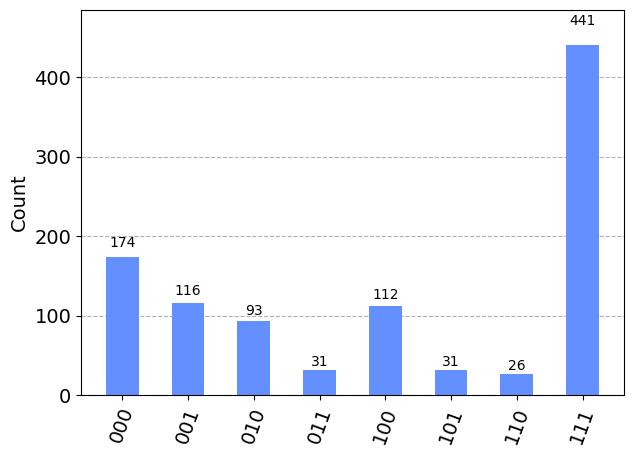

In [5]:
#Circuit simulation
counts=backend.run(optimized_qc,seed_simulator=10).result().get_counts()

plot_histogram(counts)

In [6]:
sol = max(counts,key=counts.get)
true_sol=sol[::-1] #Reverse the bitstring since the order of qubits in qiskit is inversed
w=get_cost(problem,sol)

print('The solution to the 3-SAT is',true_sol,'with',str(w),'clauses unsatisfied')

The solution to the 3-SAT is 111 with 0.0 clauses unsatisfied


### p=5

In [7]:
#Parameter optimization
optpar=optimizeparameter(problem,5)
print('The optimized \u03B3 and \u03B2 values are [\u03B3,\u03B2]=',optpar)
optimized_qc=construct_circuit(problem,optpar)
#Print the prep### p=2ared quantum circuit with the optimized parameters beta and gamma
#optimized_qc.decompose().decompose().decompose().decompose().draw('mpl')

The optimized γ and β values are [γ,β]= [0.23228992 2.5566187  0.37692307 0.84431273 0.38106779 2.37006536
 2.23209088 2.00021859 1.9953452  0.22008164]


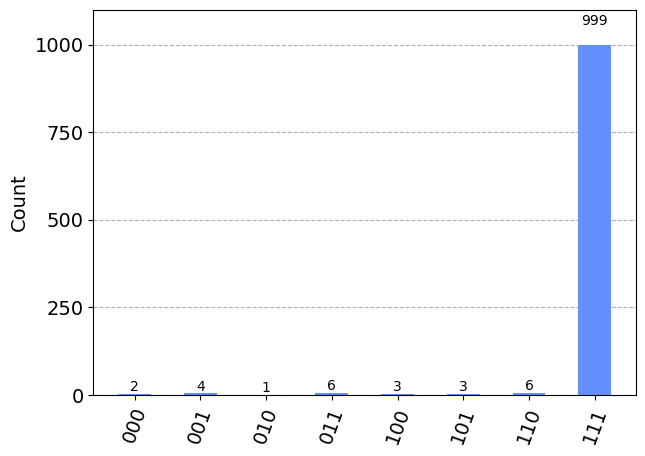

In [8]:
#Circuit simulation
counts=backend.run(optimized_qc,seed_simulator=10).result().get_counts()

plot_histogram(counts)

## Resolución del segundo problema

### p=7

In [9]:
problem=problem2
#Parameter optimization
optpar=optimizeparameter(problem,7)
print('The optimized \u03B3 and \u03B2 values are [\u03B3,\u03B2]=',optpar)
optimized_qc=construct_circuit(problem,optpar)
#Print the prepared quantum circuit with the optimized parameters beta and gamma
#optimized_qc.decompose().decompose().decompose().decompose().draw('mpl')

The optimized γ and β values are [γ,β]= [0.10838105 0.48770107 0.35850792 0.31286168 1.79756656 0.67430913
 0.91863823 0.59550542 0.84352732 0.62106699 0.59680012 1.62849787
 0.05970051 0.10599709]


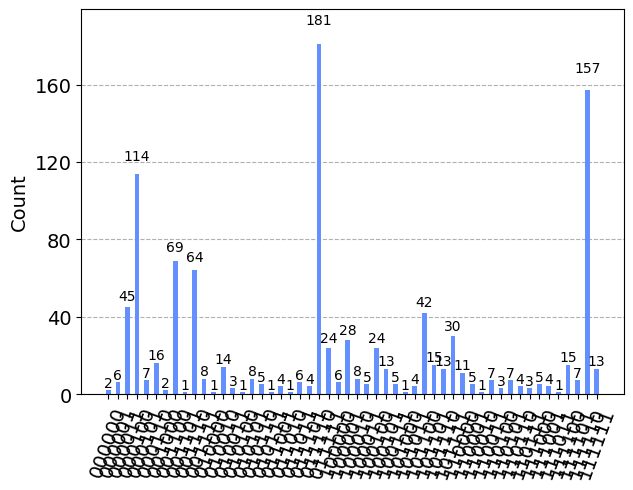

In [10]:
#Circuit simulation
counts=backend.run(optimized_qc,seed_simulator=10).result().get_counts()

plot_histogram(counts)

In [11]:
sol = max(counts,key=counts.get)
true_sol=sol[::-1] #Reverse the bitstring since the order of qubits in qiskit is inversed
w=get_cost(problem,sol)

print('The solution to the 3-SAT is',true_sol,'with',str(w),'clauses unsatisfied')

The solution to the 3-SAT is 011110 with 0.0 clauses unsatisfied


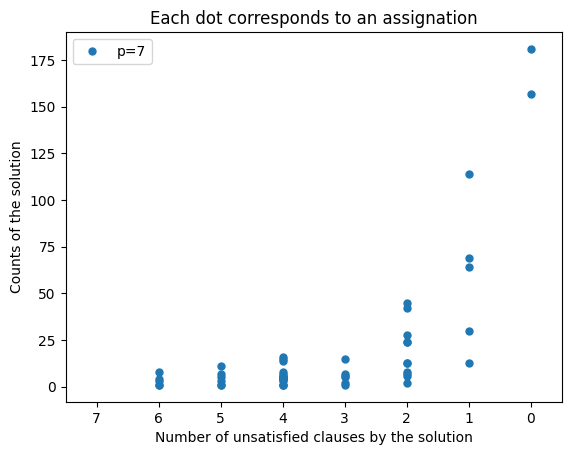

In [12]:
data={key:[value,get_cost(problem,key)] for key, value in counts.items()}
y_values = [value[0] for value in data.values()]
x_values = [value[1] for value in data.values()]

# Plotting the points
plt.plot(x_values, y_values, 'o',markersize=5)
plt.xlabel('Number of unsatisfied clauses by the solution')
plt.ylabel('Counts of the solution')
plt.title('Each dot corresponds to an assignation')
plt.legend(('p=7','p=4','p=7'),scatterpoints=1,
           loc='upper left')
plt.xlim(7.5, -0.5)
plt.grid(False)
plt.show()

### p=1,4,7
Se realiza tres simulaciones con p=1,4,7 para ver la convergencia del algoritmo QAOA en función del número de capas p

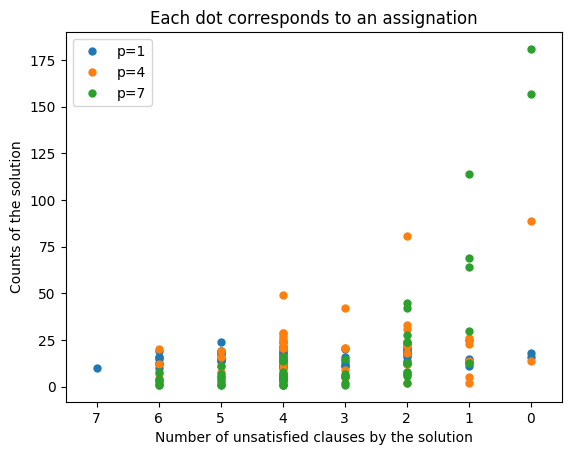

In [13]:
for i in [1,4,7]:
    optpar=optimizeparameter(problem,i)
    optimized_qc=construct_circuit(problem,optpar)
    counts=backend.run(optimized_qc,seed_simulator=10).result().get_counts()
    data={key:[value,get_cost(problem,key)] for key, value in counts.items()}
    y_values = [value[0] for value in data.values()]
    x_values = [value[1] for value in data.values()]
    plt.plot(x_values, y_values, 'o',markersize=5)
plt.xlabel('Number of unsatisfied clauses by the solution')
plt.ylabel('Counts of the solution')
plt.title('Each dot corresponds to an assignation')
plt.legend(('p=1','p=4','p=7'),scatterpoints=1,
           loc='upper left')
plt.xlim(7.5, -0.5)
plt.grid(False)
plt.show()